In [1]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
from tqdm import tqdm
import pickle
import IPython.display as ipd  # To play sound in the notebook

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/kaggle'

/content/drive/MyDrive/kaggle


In [ ]:
%cd '/content/drive/MyDrive/audio_sent'

/content/drive/MyDrive/audio_sent


In [4]:
aug_df =pd.read_csv("Data_aug_features_2.csv")

In [5]:
aug_df.shape

(48648, 435)

In [6]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(aug_df.drop(['path','labels','source'],axis=1)
                                                    , aug_df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176.1,177.1,178.1,179.1,180.1,181.1,182.1,183.1,184.1,185.1,186.1,187.1,188.1,189.1,190.1,191.1,192.1,193.1,194.1,195.1,196.1,197.1,198.1,199.1,200.1,201.1,202.1,203.1,204.1,205.1,206.1,207.1,208.1,209.1,210.1,211.1,212.1,213.1,214.1,215.1
16503,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
20510,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25180,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412,-63.055412
13443,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-40.325241,-41.585288,-41.003754,-39.278252,-39.970981,-38.998858,-38.289517,-40.310452,-40.488407,-38.375924,-36.382536,-33.559657,-33.130947,-32.778265,-33.820837,-35.206068,-36.053750,-36.551574,-38.023420,-42.718166,-43.964427,-43.781156,-46.130414,-45.356504,-44.468468,-46.312064,-44.067218,-41.981125,-40.590139,-43.002224,-42.839083,-44.134289,-45.337845,-41.258519,-36.780505,-37.664598,-41.362136,-42.372118,-43.659138,-41.185076
11879,-21.497719,-22.133261,-20.853689,-21.689516,-20.569883,-19.761827,-20.596327,-21.233427,-22.623024,-23.354519,-23.221865,-22.262117,-23.221121,-21.731457,-21.389336,-20.742558,-20.203901,-20.752562,-20.915184,-21.268278,-21.679640,-21.881956,-22.614485,-22.799711,-23.082447,-22.116264,-20.086666,-18.746788,-19.822542,-23.883701,-22.954899,-24.619509,-23.178871,-21.889383,-19.494261,-18.676025,-20.907785,-20.689562,-20.623268,-20.883419,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [7]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176.1,177.1,178.1,179.1,180.1,181.1,182.1,183.1,184.1,185.1,186.1,187.1,188.1,189.1,190.1,191.1,192.1,193.1,194.1,195.1,196.1,197.1,198.1,199.1,200.1,201.1,202.1,203.1,204.1,205.1,206.1,207.1,208.1,209.1,210.1,211.1,212.1,213.1,214.1,215.1
16503,0.456124,0.466813,0.486407,0.485698,0.484835,0.484404,0.483611,0.482946,0.482539,0.482373,0.482125,0.481729,0.480865,0.480608,0.479990,0.479346,0.478920,0.478915,0.478464,0.478543,0.478438,0.478273,0.477771,0.477869,0.477435,0.477411,0.476952,0.476639,0.476032,0.475834,0.475349,0.475548,0.475676,0.476023,0.476384,0.477354,0.478232,0.479357,0.480375,0.482248,...,0.610266,0.609958,0.609674,0.594144,0.593395,0.592856,0.576979,0.576312,0.562080,0.561635,0.561405,0.545095,0.544211,0.543173,0.528544,0.527522,0.527113,0.514850,0.514047,0.513700,0.502443,0.501969,0.501895,0.492951,0.492695,0.492722,0.479941,0.479608,0.479742,0.467391,0.466016,0.455489,0.454439,0.453801,0.442412,0.441149,0.440457,0.431169,0.429162,0.428274
20510,0.456124,0.466813,0.486407,0.485698,0.484835,0.484404,0.483611,0.482946,0.482539,0.482373,0.482125,0.481729,0.480865,0.480608,0.479990,0.479346,0.478920,0.478915,0.478464,0.478543,0.478438,0.478273,0.477771,0.477869,0.477435,0.477411,0.476952,0.476639,0.476032,0.475834,0.475349,0.475548,0.475676,0.476023,0.476384,0.477354,0.478232,0.479357,0.480375,0.482248,...,0.610266,0.609958,0.609674,0.594144,0.593395,0.592856,0.576979,0.576312,0.562080,0.561635,0.561405,0.545095,0.544211,0.543173,0.528544,0.527522,0.527113,0.514850,0.514047,0.513700,0.502443,0.501969,0.501895,0.492951,0.492695,0.492722,0.479941,0.479608,0.479742,0.467391,0.466016,0.455489,0.454439,0.453801,0.442412,0.441149,0.440457,0.431169,0.429162,0.428274
25180,0.456124,0.466813,0.486407,0.485698,0.484835,0.484404,0.483611,0.482946,0.482539,0.482373,0.482125,0.481729,0.480865,0.480608,0.479990,0.479346,0.478920,0.478915,0.478464,0.478543,0.478438,0.478273,0.477771,0.477869,0.477435,0.477411,0.476952,0.476639,0.476032,0.475834,0.475349,0.475548,0.475676,0.476023,0.476384,0.477354,0.478232,0.479357,0.480375,0.482248,...,-2.207082,-2.199428,-2.193482,-2.228095,-2.225484,-2.222745,-2.265046,-2.269658,-2.311166,-2.312943,-2.313417,-2.367123,-2.371349,-2.375267,-2.423817,-2.430368,-2.433709,-2.476751,-2.482864,-2.485475,-2.524254,-2.528972,-2.531410,-2.564906,-2.568638,-2.570343,-2.622935,-2.626638,-2.628535,-2.691331,-2.711036,-2.770451,-2.790445,-2.805393,-2.872928,-2.895858,-2.913911,-2.974302,-2.994037,-2.991884
13443,0.456124,0.466813,0.486407,0.485698,0.484835,0.484404,0.483611,0.482946,0.482539,0.482373,0.482125,0.481729,0.480865,0.480608,0.479990,0.479346,0.478920,0.478915,0.478464,0.478543,0.478438,0.478273,0.477771,0.477869,0.477435,0.477411,0.476952,0.476639,0.476032,0.475834,0.475349,0.475548,0.475676,0.476023,0.476384,0.477354,0.478232,0.479357,0.480375,0.482248,...,-1.191486,-1.242843,-1.213166,-1.163875,-1.193499,-1.148552,-1.148801,-1.243077,-1.282855,-1.187851,-1.097347,-1.004860,-0.987700,-0.973927,-1.055005,-1.123972,-1.165823,-1.219303,-1.293138,-1.518152,-1.607876,-1.602499,-1.717227,-1.706601,-1.666244,-1.756996,-1.688550,-1.588473,-1.521124,-1.686779,-1.692435,-1.802439,-1.878684,-1.678760,-1.491441,-1.552130,-1.759890,-1.857247,-1.941037,-1.805626
11879,-1.395224,-1.436453,-1.188360,-1.259036,-1.173078,-1.111551,-1.183475,-1.238029,-1.355205,-1.416515,-1.409484,-1.334624,-1.417748,-1.299853,-1.277282,-1.227314,-1.186997,-1.233913,-1.250367,-1.280969,-1.317389,-1.335036,-1.397685,-1.414587,-1.440864,-1.361370,-1.194648,-1.083655,-1.175695,-1.516001,-1.441285,-1.580938,-1.465865,-1.360454,-1.164433,-1.100571,-1.296538,-1.285820,-1.290515,-1.321832,...,0.610266,0.609958,0.609674,0.594144,0.593395,0.592856,0.576979,0.576312,0.562080,0.561635,0.561405,0.545095,0.544211,0.543173,0.528544,0.527522,0.527113,0.514850,0.514047,0.513700,0.502443,0.501969,0.501895,0.492951,0.492695,0.492722,0

In [8]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(36486, 432)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [9]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(36486, 432, 1)

In [10]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
opt = optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 432, 256)          2304      
_________________________________________________________________
activation (Activation)      (None, 432, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 432, 256)          524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 432, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 432, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 432, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 54, 256)           0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [11]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test),verbose=2)

Epoch 1/100
2281/2281 - 110s - loss: 2.3497 - accuracy: 0.1928 - val_loss: 2.2893 - val_accuracy: 0.2319
Epoch 2/100
2281/2281 - 79s - loss: 2.1444 - accuracy: 0.2524 - val_loss: 2.1772 - val_accuracy: 0.2581
Epoch 3/100
2281/2281 - 79s - loss: 2.0486 - accuracy: 0.2824 - val_loss: 2.1108 - val_accuracy: 0.2847
Epoch 4/100
2281/2281 - 79s - loss: 1.9803 - accuracy: 0.3086 - val_loss: 2.0790 - val_accuracy: 0.2862
Epoch 5/100
2281/2281 - 79s - loss: 1.9280 - accuracy: 0.3263 - val_loss: 1.9936 - val_accuracy: 0.3342
Epoch 6/100
2281/2281 - 79s - loss: 1.8840 - accuracy: 0.3397 - val_loss: 1.9625 - val_accuracy: 0.3420
Epoch 7/100
2281/2281 - 79s - loss: 1.8493 - accuracy: 0.3550 - val_loss: 1.9698 - val_accuracy: 0.3211
Epoch 8/100
2281/2281 - 79s - loss: 1.8194 - accuracy: 0.3625 - val_loss: 1.9010 - val_accuracy: 0.3573
Epoch 9/100
2281/2281 - 79s - loss: 1.7941 - accuracy: 0.3736 - val_loss: 1.8914 - val_accuracy: 0.3592
Epoch 10/100
2281/2281 - 79s - loss: 1.7692 - accuracy: 0.3827 

In [12]:
# Save model and weights
model_name = 'Emotion_Model_aug_2.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json_aug_2.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /content/drive/My Drive/kaggle/saved_models/Emotion_Model_aug_2.h5 


In [14]:
from tensorflow.keras import optimizers

In [15]:
# loading json and model architecture 
json_file = open('model_json_aug_2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model_aug_2.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


accuracy: 46.80%


In [16]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

761/761 [==============================] - 7s 9ms/step


array([ 2,  3,  3, ...,  5, 11,  7])

In [17]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,female_disgust,female_fear
171,female_happy,female_surprise
172,female_neutral,female_neutral
173,male_disgust,female_sad
174,female_neutral,female_neutral
175,female_happy,female_fear
176,female_angry,female_angry
177,female_happy,male_happy
178,female_neutral,female_angry
179,male_neutral,male_neutral


In [18]:
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,1187
female_disgust,956
female_fear,954
female_happy,1332
female_neutral,1404
female_sad,974
female_surprise,493
male_angry,596
male_disgust,816


In [24]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    '''Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    '''
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


0.4680151290906101


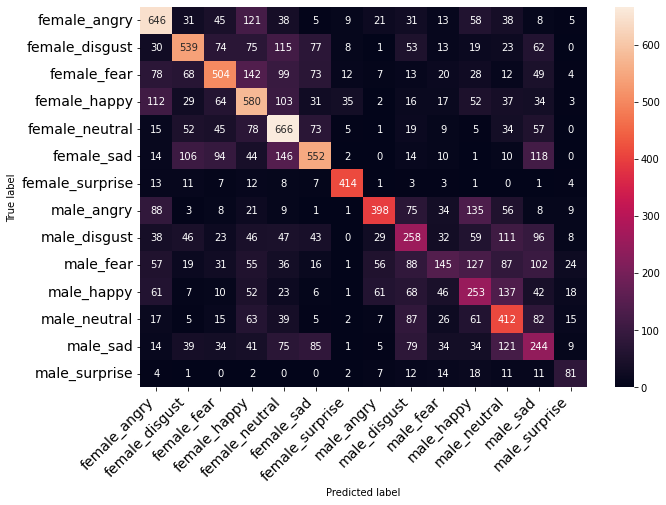

In [25]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [23]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.54      0.60      0.57      1069
 female_disgust       0.56      0.49      0.53      1089
    female_fear       0.53      0.45      0.49      1109
   female_happy       0.44      0.52      0.47      1115
 female_neutral       0.47      0.63      0.54      1059
     female_sad       0.57      0.50      0.53      1111
female_surprise       0.84      0.85      0.85       485
     male_angry       0.67      0.47      0.55       846
   male_disgust       0.32      0.31      0.31       836
      male_fear       0.35      0.17      0.23       844
     male_happy       0.30      0.32      0.31       785
   male_neutral       0.38      0.49      0.43       836
       male_sad       0.27      0.30      0.28       815
  male_surprise       0.45      0.50      0.47       163

       accuracy                           0.47     12162
      macro avg       0.48      0.47      0.47     12162
   weighted avg       0.47   